# Encoder-Decoder Model with Attention: 1 Layer LSTM & Scratch Embedding 
# (Word Level)

## Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import re
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Flatten, Activation 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [ ]:
data_path = '/content/drive/MyDrive/CS2/2.Datasets/'
model_path = '/content/drive/MyDrive/CS2/3.Models/4_2_Attention-Word-Scratch/'

In [ ]:
data = pd.read_csv(data_path + 'final_data.csv')
print(data.shape)
data.head()

(101717, 2)


,input_text,output_text
0,"Ofcouse , I love cheap fashion , fast fashion ...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,I 'm gon na earn enough money to study abroad .
4,It is not difficult for me but answer phones a...,It is not difficult for me but answering the p...


## Preprocess Data

In [ ]:
def clean(text):
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

data['input_text'] = data['input_text'].apply(lambda x: clean(x))
data['output_text'] = data['output_text'].apply(lambda x: clean(x))

In [ ]:
def preprocessing(data):
   
    data['input_text_length'] = data['input_text'].str.split().apply(len)
    data['output_text_length'] = data['output_text'].str.split().apply(len)

    data = data[data['input_text_length'] < 25]
    data = data[data['output_text_length'] < 25]

    data['output_text_in'] = '<start> ' + data['output_text'].astype(str)
    data['output_text_out'] = data['output_text'].astype(str) + ' <end>'

    data = data.drop(['input_text_length','output_text_length','output_text'], axis=1)
    return data

In [ ]:
data = preprocessing(data)

data.iloc[0]['output_text_in'] = str(data.iloc[0]['output_text_in'])+' <end>'
data.iloc[0]['output_text_out'] = str(data.iloc[0]['output_text_out'])+' <end>'

print('Shape of Dataset:', data.shape)
data.head()

Shape of Dataset: (93503, 3)


,input_text,output_text_in,output_text_out
0,"Ofcouse , I love cheap fashion , fast fashion ...","<start> Of course , I love cheap , fast fashio...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,<start> If he wants to listen to music that I ...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,<start> This happened because of the cultural ...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,<start> I 'm gon na earn enough money to study...,I 'm gon na earn enough money to study abroad ...
4,It is not difficult for me but answer phones a...,<start> It is not difficult for me but answeri...,It is not difficult for me but answering the p...


## Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
print('Shape of Train Data:', train.shape)
print('Shape of Test Data:', test.shape)

Shape of Train Data: (84152, 3)
Shape of Test Data: (9351, 3)


## Tokenization

In [ ]:
tokenizer_i = Tokenizer(filters="", char_level=False, lower=False)
tokenizer_o = Tokenizer(filters="", char_level=False, lower=False)

tokenizer_i.fit_on_texts(train['input_text'].values)
tokenizer_o.fit_on_texts(train['output_text_in'].values)

vocab_size_input = len(tokenizer_i.word_index.keys())
print('Input Vocab Size:', vocab_size_input)

vocab_size_output = len(tokenizer_o.word_index.keys())
print('Output Vocab Size:', vocab_size_output)

Input Vocab Size: 35510
Output Vocab Size: 29350


## Data Pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tokenizer_i, tokenizer_o, max_len_enc, max_len_dec):
        self.encoder_inps = data['input_text'].values
        self.decoder_inps = data['output_text_in'].values
        self.decoder_outs = data['output_text_out'].values
        self.tokenizer_o = tokenizer_o
        self.tokenizer_i = tokenizer_i
        self.max_len_enc = max_len_enc
        self.max_len_dec = max_len_dec


    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_i.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tokenizer_o.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_o.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_enc, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self): 
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_i, tokenizer_o, 25, 25)
test_dataset  = Dataset(test, tokenizer_i, tokenizer_o, 25, 25)

train_dataloader = Dataloder(train_dataset, batch_size=512)
test_dataloader = Dataloder(test_dataset, batch_size=512)

print('Train Dataloader:', train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print('Test Dataloader:', test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

Train Dataloader: (512, 25) (512, 25) (512, 25)
Test Dataloader: (512, 25) (512, 25) (512, 25)


## Model Building

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self,in_vocab_size,embedding_dim,enc_units,input_length):
        super().__init__()
        self.in_vocab_size = in_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units = enc_units

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.in_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Encoder_Embedding")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentences, training=True):
        input_embed = self.embedding(input_sentences)
        encoder_output, encoder_state_h, encoder_state_c = self.lstm(input_embed)
        return encoder_output, encoder_state_h, encoder_state_c

#-----------------------------------------------------------------------------------------------------------------------------------
class Attention(tf.keras.layers.Layer):
  '''
  Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units

    if self.scoring_function == 'dot':
      pass

    if scoring_function == 'general':
      self.W = Dense(self.att_units)
      
    elif scoring_function == 'concat':
      self.W1 = Dense(self.att_units)
      self.W2 = Dense(self.att_units)
      self.Va = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    if self.scoring_function == 'dot':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(encoder_output, decoder_hidden_state)

    elif self.scoring_function == 'general':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(self.W(encoder_output), decoder_hidden_state)

    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.Va(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))

    attention_weight = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum(attention_weight * encoder_output, axis=1)
    return context_vector, attention_weight

#-----------------------------------------------------------------------------------------------------------------------------------
class One_Step_Decoder(tf.keras.Model):
  def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units= dec_units
      self.score_fun = score_fun
      self.att_units = att_units

  def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, name="Decoder_Embedding")
        self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
        self.dense = Dense(self.tar_vocab_size)
        self.attention = Attention(self.score_fun, self.att_units)

  def call(self,input_to_decoder, encoder_output, state_h, state_c):
    
    target_embedd = self.embedding(input_to_decoder)

    context_vector, attention_weights = self.attention(state_h, encoder_output)
    context_vector = tf.expand_dims(context_vector, 1)

    decoder_input = tf.concat([target_embedd, context_vector], 2)

    decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(decoder_input, initial_state=[state_h,state_c])

    output = self.dense(decoder_output)

    return tf.squeeze(output), decoder_final_state_h, decoder_final_state_c, attention_weights, tf.squeeze(context_vector)

#-----------------------------------------------------------------------------------------------------------------------------------
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun, att_units):
      super(Decoder, self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.one_step_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

   
    def call(self, input_to_decoder, encoder_output_state, decoder_hidden_state, decoder_cell_state):
      all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name="output_arrays")

      for timestep in range(tf.shape(input_to_decoder)[1]):
        output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:,timestep:timestep+1], encoder_output_state, decoder_hidden_state, decoder_cell_state)
        all_outputs = all_outputs.write(timestep, output)

      all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
      return all_outputs

#-----------------------------------------------------------------------------------------------------------------------------------
class Encoder_Decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length, decoder_inputs_length, input_vocab_size, output_vocab_size, embedding_dim, enc_units, dec_units, att_units, batch_size, score_fun, name='Encoder-Decoder-Attention'):
    super().__init__(name=name)
    self.encoder = Encoder(in_vocab_size=input_vocab_size+1, embedding_dim=embedding_dim, enc_units=enc_units, input_length=encoder_inputs_length)
    self.decoder = Decoder(out_vocab_size=output_vocab_size+1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.batch_size = batch_size

  def call(self,data):

    input, output = data[0], data[1]

    encoder_output, encoder_h, encoder_c = self.encoder(input)
    decoder_output = self.decoder(output, encoder_output, encoder_h, encoder_c)
    return decoder_output

## Custom Loss Function

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Model Training

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=64, 
                          dec_units=64, 
                          att_units=64,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)

40 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history40 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=40, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/40
164/164 [==============================] - 128s 747ms/step - loss: 3.6338 - val_loss: 3.0872
Epoch 2/40
164/164 [==============================] - 121s 741ms/step - loss: 3.0231 - val_loss: 2.9271
Epoch 3/40
164/164 [==============================] - 121s 741ms/step - loss: 2.8560 - val_loss: 2.7758
Epoch 4/40
164/164 [==============================] - 122s 746ms/step - loss: 2.7168 - val_loss: 2.6320
Epoch 5/40
164/164 [==============================] - 121s 738ms/step - loss: 2.5650 - val_loss: 2.4841
Epoch 6/40
164/164 [==============================] - 122s 742ms/step - loss: 2.4299 - val_loss: 2.3620
Epoch 7/40
164/164 [==============================] - 121s 741ms/step - loss: 2.3216 - val_loss: 2.2635
Epoch 8/40
164/164 [==============================] - 121s 740ms/step - loss: 2.2298 - val_loss: 2.1775
Epoch 9/40
164/164 [==============================] - 121s 738ms/step - loss: 2.1449 - val_loss: 2.0938
Epoch 10/40
164/164 [==============================] - 122s 742m

In [ ]:
model.save_weights(model_path + 'att40/' + 'attention40', save_format='tf') 

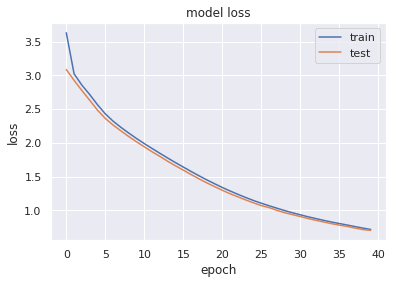

In [ ]:
plt.plot(history40.history['loss'])
plt.plot(history40.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

Model: "Encoder-Decoder-Attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  10746740  
_________________________________________________________________
decoder_1 (Decoder)          multiple                  10822939  
Total params: 21,569,679
Trainable params: 21,569,679
Non-trainable params: 0
_________________________________________________________________


80 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history80 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=40, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/40
164/164 [==============================] - 119s 729ms/step - loss: 0.6972 - val_loss: 0.6780
Epoch 2/40
164/164 [==============================] - 121s 736ms/step - loss: 0.6791 - val_loss: 0.6609
Epoch 3/40
164/164 [==============================] - 120s 729ms/step - loss: 0.6627 - val_loss: 0.6439
Epoch 4/40
164/164 [==============================] - 121s 738ms/step - loss: 0.6470 - val_loss: 0.6308
Epoch 5/40
164/164 [==============================] - 122s 742ms/step - loss: 0.6306 - val_loss: 0.6129
Epoch 6/40
164/164 [==============================] - 120s 729ms/step - loss: 0.6132 - val_loss: 0.5958
Epoch 7/40
164/164 [==============================] - 121s 738ms/step - loss: 0.5975 - val_loss: 0.5820
Epoch 8/40
164/164 [==============================] - 120s 733ms/step - loss: 0.5839 - val_loss: 0.5691
Epoch 9/40
164/164 [==============================] - 120s 732ms/step - loss: 0.5719 - val_loss: 0.5571
Epoch 10/40
164/164 [==============================] - 121s 736m

In [ ]:
model.save_weights(model_path + 'att80/' + 'attention80', save_format='tf') 

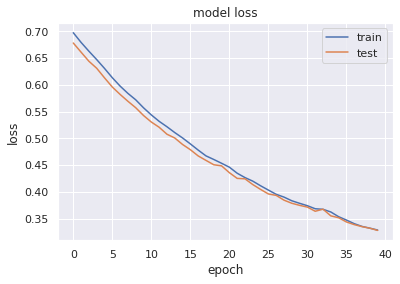

In [ ]:
plt.plot(history80.history['loss'])
plt.plot(history80.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

90 Epoch

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=64, 
                          dec_units=64, 
                          att_units=64,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
model.load_weights(model_path + 'att80/' + 'attention80')

In [ ]:
with tf.device('/device:GPU:0'): 
    history90 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 127s 742ms/step - loss: 0.3248 - val_loss: 0.3241
Epoch 2/10
164/164 [==============================] - 119s 729ms/step - loss: 0.3231 - val_loss: 0.3199
Epoch 3/10
164/164 [==============================] - 120s 733ms/step - loss: 0.3173 - val_loss: 0.3150
Epoch 4/10
164/164 [==============================] - 120s 732ms/step - loss: 0.3130 - val_loss: 0.3157
Epoch 5/10
164/164 [==============================] - 119s 726ms/step - loss: 0.3112 - val_loss: 0.3106
Epoch 6/10
164/164 [==============================] - 120s 732ms/step - loss: 0.3082 - val_loss: 0.3088
Epoch 7/10
164/164 [==============================] - 120s 733ms/step - loss: 0.3061 - val_loss: 0.3049
Epoch 8/10
164/164 [==============================] - 118s 723ms/step - loss: 0.3039 - val_loss: 0.3018
Epoch 9/10
164/164 [==============================] - 120s 733ms/step - loss: 0.2966 - val_loss: 0.2970
Epoch 10/10
164/164 [==============================] - 120s 730m

In [ ]:
model.save_weights(model_path + 'att90/' + 'attention90', save_format='tf') 

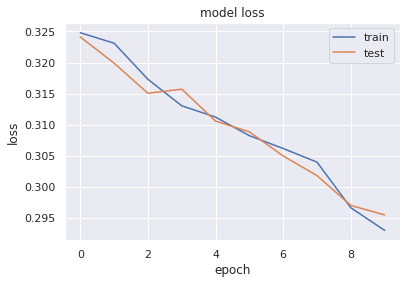

In [ ]:
plt.plot(history90.history['loss'])
plt.plot(history90.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

100 Epoch

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0001)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=64, 
                          dec_units=64, 
                          att_units=64,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
model.load_weights(model_path + 'att90/' + 'attention90')

In [ ]:
with tf.device('/device:GPU:0'): 
    history100 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 129s 728ms/step - loss: 0.2897 - val_loss: 0.2906
Epoch 2/10
164/164 [==============================] - 118s 719ms/step - loss: 0.2860 - val_loss: 0.2873
Epoch 3/10
164/164 [==============================] - 117s 716ms/step - loss: 0.2822 - val_loss: 0.2828
Epoch 4/10
164/164 [==============================] - 116s 710ms/step - loss: 0.2785 - val_loss: 0.2799
Epoch 5/10
164/164 [==============================] - 117s 714ms/step - loss: 0.2758 - val_loss: 0.2799
Epoch 6/10
164/164 [==============================] - 117s 714ms/step - loss: 0.2744 - val_loss: 0.2760
Epoch 7/10
164/164 [==============================] - 117s 715ms/step - loss: 0.2726 - val_loss: 0.2742
Epoch 8/10
164/164 [==============================] - 117s 711ms/step - loss: 0.2698 - val_loss: 0.2710
Epoch 9/10
164/164 [==============================] - 116s 710ms/step - loss: 0.2671 - val_loss: 0.2717
Epoch 10/10
164/164 [==============================] - 117s 712m

In [ ]:
model.save_weights(model_path + 'att100/' + 'attention100', save_format='tf') 

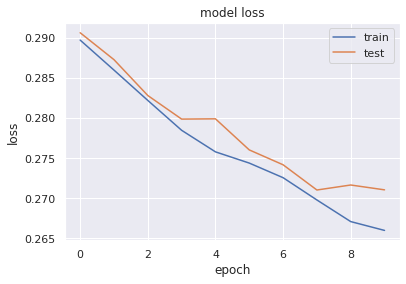

In [ ]:
plt.plot(history100.history['loss'])
plt.plot(history100.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

110 Epoch

In [ ]:
optimizer = tf.keras.optimizers.Adam()

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=64, 
                          dec_units=64, 
                          att_units=64,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
model.load_weights(model_path + 'att100/' + 'attention100')

In [ ]:
with tf.device('/device:GPU:0'): 
    history110 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 136s 738ms/step - loss: 0.2639 - val_loss: 0.2667
Epoch 2/10
164/164 [==============================] - 119s 724ms/step - loss: 0.2610 - val_loss: 0.2630
Epoch 3/10
164/164 [==============================] - 118s 721ms/step - loss: 0.2572 - val_loss: 0.2633
Epoch 4/10
164/164 [==============================] - 119s 727ms/step - loss: 0.2559 - val_loss: 0.2559
Epoch 5/10
164/164 [==============================] - 119s 726ms/step - loss: 0.2532 - val_loss: 0.2577
Epoch 6/10
164/164 [==============================] - 118s 723ms/step - loss: 0.2518 - val_loss: 0.2584
Epoch 7/10
164/164 [==============================] - 119s 729ms/step - loss: 0.2481 - val_loss: 0.2508
Epoch 8/10
164/164 [==============================] - 118s 721ms/step - loss: 0.2451 - val_loss: 0.2484
Epoch 9/10
164/164 [==============================] - 119s 726ms/step - loss: 0.2423 - val_loss: 0.2483
Epoch 10/10
164/164 [==============================] - 119s 724m

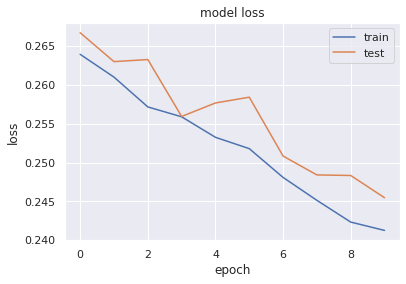

In [ ]:
plt.plot(history110.history['loss'])
plt.plot(history110.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
with tf.device('/device:GPU:0'): 
    history120 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 117s 716ms/step - loss: 0.2404 - val_loss: 0.2446
Epoch 2/10
164/164 [==============================] - 119s 727ms/step - loss: 0.2393 - val_loss: 0.2427
Epoch 3/10
164/164 [==============================] - 118s 721ms/step - loss: 0.2394 - val_loss: 0.2458
Epoch 4/10
164/164 [==============================] - 134s 817ms/step - loss: 0.2422 - val_loss: 0.2430
Epoch 5/10
164/164 [==============================] - 119s 725ms/step - loss: 0.2374 - val_loss: 0.2400
Epoch 6/10
164/164 [==============================] - 118s 719ms/step - loss: 0.2325 - val_loss: 0.2350
Epoch 7/10
164/164 [==============================] - 133s 812ms/step - loss: 0.2282 - val_loss: 0.2350
Epoch 8/10
164/164 [==============================] - 118s 719ms/step - loss: 0.2264 - val_loss: 0.2349
Epoch 9/10
164/164 [==============================] - 118s 723ms/step - loss: 0.2255 - val_loss: 0.2310
Epoch 10/10
164/164 [==============================] - 118s 721m

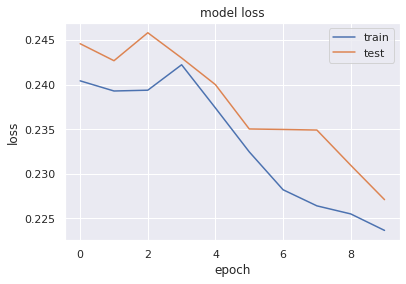

In [ ]:
plt.plot(history120.history['loss'])
plt.plot(history120.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
with tf.device('/device:GPU:0'): 
    history130 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 119s 728ms/step - loss: 0.2321 - val_loss: 0.2329
Epoch 2/10
164/164 [==============================] - 117s 714ms/step - loss: 0.2287 - val_loss: 0.2301
Epoch 3/10
164/164 [==============================] - 119s 723ms/step - loss: 0.2217 - val_loss: 0.2247
Epoch 4/10
164/164 [==============================] - 119s 725ms/step - loss: 0.2183 - val_loss: 0.2212
Epoch 5/10
164/164 [==============================] - 118s 719ms/step - loss: 0.2156 - val_loss: 0.2222
Epoch 6/10
164/164 [==============================] - 118s 720ms/step - loss: 0.2133 - val_loss: 0.2185
Epoch 7/10
164/164 [==============================] - 119s 726ms/step - loss: 0.2122 - val_loss: 0.2190
Epoch 8/10
164/164 [==============================] - 118s 719ms/step - loss: 0.2317 - val_loss: 0.2406
Epoch 9/10
164/164 [==============================] - 119s 725ms/step - loss: 0.2275 - val_loss: 0.2250
Restoring model weights from the end of the best epoch.
Epoch 00

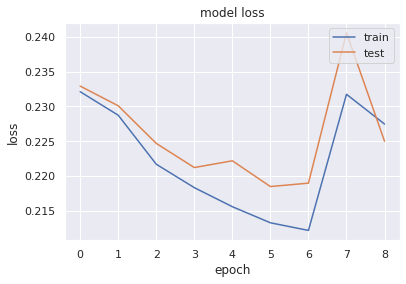

In [ ]:
plt.plot(history130.history['loss'])
plt.plot(history130.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model Prediction

In [ ]:
def predict(input_sentence):

  batch_size = 1 
  DECODER_SEQ_LEN = 25
  predict_word_idx = np.zeros((1, 1))
  predict_word_idx[0,0] = 1
  predicted_sentence = ''

  input_sequence=tokenizer_i.texts_to_sequences([input_sentence])
  inputs=pad_sequences(input_sequence,maxlen=25,padding='post')
  inputs=tf.convert_to_tensor(inputs)

  enc_output, state_h, state_c = model.layers[0](inputs)

  for i in range(DECODER_SEQ_LEN):
      dec_output, state_h, state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(predict_word_idx, enc_output, state_h, state_c)
      predict_word_idx = np.reshape(np.argmax(dec_output), (1, 1))
      predicted_sentence += ' ' + tokenizer_o.index_word[int(predict_word_idx)]

      if tokenizer_o.word_index['<end>'] == predict_word_idx:
          return predicted_sentence
      dec_input = tf.expand_dims([predict_word_idx],0)
  return predicted_sentence

#----------------------------------------------------------------------------------------------------
import nltk.translate.bleu_score as bleu

def get_BLEU(model, train, test):
    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(train['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(train['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    train_avg_bleu = total_bleu/input_range

    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(test['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(test['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    test_avg_bleu = total_bleu/input_range

    print('Train BLEU Score:', train_avg_bleu)
    print('Test BLEU Score:', test_avg_bleu)

In [ ]:
print('SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS')
print('-'*50)

print('Epoch 40')
model.load_weights(model_path + 'att40/' + 'attention40')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 80')
model.load_weights(model_path + 'att80/' + 'attention80')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 90')
model.load_weights(model_path + 'att90/' + 'attention90')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 100')
model.load_weights(model_path + 'att100/' + 'attention100')
get_BLEU(model, train, test)
print('='*50)

SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS
--------------------------------------------------
Epoch 40
Train BLEU Score: 0.5002942961089942
Test BLEU Score: 0.42947934300616775
Epoch 80
Train BLEU Score: 0.7162684853943179
Test BLEU Score: 0.43488871708642035
Epoch 90
Train BLEU Score: 0.7629772712505434
Test BLEU Score: 0.4607488004938597
Epoch 100
Train BLEU Score: 0.743112537162625
Test BLEU Score: 0.445549023670435


In [ ]:
model.load_weights(model_path + 'att90/' + 'attention90')

Train

In [ ]:
for i in range(len(train[:5])):
    print("Input Text:", train['input_text'].iloc[i])
    print("Output Text:", ' '.join(train['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(train['input_text'].iloc[i]).split()[:-1]))
    print('='*120)

Input Text: At the party , the member has variety job .
Output Text: At the party , the members have a variety of jobs .
Predicted Text: At the party , the members have a variety of jobs .
Input Text: Thank you NY .
Output Text: Thank you , NY !
Predicted Text: Thank you :
Input Text: Few last days have been strange .
Output Text: The last few days have been strange .
Predicted Text: A last few days have been strange .
Input Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking for with people around me .
Output Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with the people around me .
Predicted Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with the people around me .
Input Text: We also often listen to the CD which includes the conversation amongst native speakers .
Output Text: We also often listened to the CD which includes

Test

In [ ]:
for i in range(len(test[:5])):
    print("Input Text:", test['input_text'].iloc[i])
    print("Output Text:", ' '.join(test['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(test['input_text'].iloc[i]).split()[:-1]))
    print('='*120)

Input Text: Have you ever over the wall of school ?
Output Text: Have you ever climbed over the wall at school ?
Predicted Text: Have you ever taken by the wall of school ?
Input Text: It is so narrow that I have to keep my body very fit everytime .
Output Text: It is so narrow that I have to keep my body very fit all the time .
Predicted Text: It is so fast that I have to keep my thoughts very paid back our teeth .
Input Text: You can check the maintenance is finished or not at twitter .
Output Text: You can check whether the maintenance is finished or not on twitter .
Predicted Text: You can check the maintenance is finished or not at Twitter .
Input Text: Anyone who gets higher than  scores can pass it .
Output Text: Anyone who gets higher than a , passes it or passes the exam .
Predicted Text: recommend : he gets higher than I have passed it .
Input Text: I talked with Rie about our job , but it was a short time .
Output Text: I talked with Rie about our job , but it was just for a